# Utilize Cycle-StarNet to identify "uknown" lines

This notebook goes through the procedure to correlate elements to lines that are missing from the synthetic line list. We are using the model that has been trained using Payne spectra with noise added (minimum S/N of 50) as the "observed" dataset, which are generated from the entire line list. The "synthetic" spectra used to train the model are also Payne spectra, but many of the lines have been masked in the form of setting them to the continuum level.

Since both domains consist of the same underlying parameters (ie. the stellar labels: $T_{\mathrm{eff}}$, $\log{(g)}$, abundances, etc.) and only differ in the asthetics (ie. missing lines and noise), there is no need to use a *split latent-space*.

In order to identify these "uknown" lines (the masked lines), we need to locate the lines in our observed spectra and determine which element they are most strongly correlated to.

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib import gridspec

from cycler import cycler

from scipy import optimize
import numpy as np
import os
import configparser
import sys
sys.path.append('../')

import torch
import torch.nn as nn

from network import CycleSN
from training_fns import batch_to_cuda, create_synth_batch, CSNDataset
from analysis_fns import (apstarwavegrid, plot_spec_resid_density, tsne_domain_analysis2)

model_name = 'new_lines_1'

use_cuda = torch.cuda.is_available()
if use_cuda:
    print('Using GPU!')
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')

Using GPU!


In [2]:
# define plot properties
import matplotlib.cm as cm

from matplotlib import rcParams
from matplotlib import rc
from mpl_toolkits.axes_grid1 import make_axes_locatable

def rgb(r,g,b):
    return (float(r)/256.,float(g)/256.,float(b)/256.)

cb2 = [rgb(31,120,180), rgb(255,127,0), rgb(51,160,44), rgb(227,26,28), \
       rgb(10,10,10), rgb(253,191,111), rgb(178,223,138), rgb(251,154,153)]

rcParams['figure.figsize'] = (11,7.5)
rcParams['figure.dpi'] = 300

rcParams['lines.linewidth'] = 1

rcParams['axes.prop_cycle'] = cycler('color', cb2)
rcParams['axes.facecolor'] = 'white'
rcParams['axes.grid'] = False

rcParams['patch.facecolor'] = cb2[0]
rcParams['patch.edgecolor'] = 'white'

rcParams['font.family'] = 'Bitstream Vera Sans' 
rcParams['font.size'] = 25
rcParams['font.weight'] = 500

First we will load the model configuration, which consists of the hyper-parameters that define the architecture and training process for this particular model.

In [3]:
# Directories
csn_dir = '..'
config_dir = os.path.join(csn_dir, 'configs/')
model_dir = os.path.join(csn_dir, 'models/')
data_dir = os.path.join(csn_dir, 'data/')

# Model configuration
config = configparser.ConfigParser()
config.read(config_dir+model_name+'.ini')
architecture_config = config['ARCHITECTURE']

print('\nCreating model: %s'%model_name)
print('\nConfiguration:')

for key_head in config.keys():
    if key_head=='DEFAULT':
        continue
    print('  %s' % key_head)
    for key in config[key_head].keys():
        print('    %s: %s'%(key, config[key_head][key]))
        
# DATA FILES
data_file_synth = os.path.join(data_dir, config['DATA']['data_file_synth'])
data_file_obs = os.path.join(data_dir, config['DATA']['data_file_obs'])
spectra_norm_file = os.path.join(data_dir, config['DATA']['spectra_norm_file'])
emulator_fn = os.path.join(model_dir, config['DATA']['emulator_fn'])


Creating model: new_lines_1

Configuration:
  DATA
    spectra_norm_file: mean_and_std_PAYNE_specs.npy
    data_file_synth: csn_kurucz.h5
    data_file_obs: csn_apogee_mock.h5
    emulator_fn: PAYNE.pth.tar
  TRAINING
    batchsize: 8
    learning_rate_encoder: 0.0001
    learning_rate_decoder: 0.0001
    learning_rate_discriminator: 0.0001
    loss_weight_synth: 90
    loss_weight_obs: 90
    loss_weight_gen: 1
    loss_weight_dis: 1
    lr_decay_batch_iters_rg: [5e4,10e4,15e4,20e4,25e5]
    lr_decay_batch_iters_dis: [5e4,10e4,15e4,20e4,25e5]
    lr_decay_rg: 0.7
    lr_decay_dis: 0.7
    total_batch_iters: 5e5
    use_real_as_true: False
    mask_synth_lines: True
  ARCHITECTURE
    num_pixels: 7167
    activation: LeakyReLU
    conv_filts_ae_dom: [32, 64]
    conv_filt_lens_ae_dom: [7, 7]
    conv_strides_ae_dom: [4, 4]
    conv_filts_ae_sh: [128, 256, 512]
    conv_filt_lens_ae_sh: [7, 7, 7]
    conv_strides_ae_sh: [4, 2, 2]
    conv_filts_ae_sp: [32, 32, 32]
    conv_filt_lens_ae

Now we will create the model architecture which consists of:
- The Emulator, $Payne$, that takes the stellar labels, $y$, as inputs and produces synthetic spectra
- The Endoders, $E_{synth}$ and $E_{obs}$, which take spectra from their respective domains and produce the shared latent-variables, $z_{shared}$
- The Decoders, $D_{synth}$ and $D_{obs}$, which take the shared latent-variables, $z_{shared}$, and produce spectra back into their respective domains 

In [4]:
# BUILD THE NETWORKS

print('\nBuilding networks...')
model = CycleSN(architecture_config, emulator_fn, use_cuda=use_cuda)

# Display model architectures
print('\n\nSYNTHETIC EMULATOR ARCHITECTURE:\n')
print(model.emulator)
print('\n\nENCODER_synth and ENCODER_obs ARCHITECTURE:\n')
print(model.encoder_synth)
print('\n\nENCODER_sh ARCHITECTURE:\n')
print(model.encoder_sh)
if model.use_split:
    print('\n\nENCODER_sp ARCHITECTURE:\n')
    print(model.encoder_sp)
    print('\n\nDECODER_sp ARCHITECTURE:\n')
    print(model.decoder_sp)
print('\n\nDECODER_sh ARCHITECTURE:\n')
print(model.decoder_sh)
print('\n\nDECODER_synth and DECODER_obs ARCHITECTURE:\n')
print(model.decoder_synth)
print('\n\nDISCRIM_synth and DISCRIM_obs ARCHITECTURE:\n')
print(model.discriminator_synth)


Building networks...


SYNTHETIC EMULATOR ARCHITECTURE:

Sequential(
  (0): Linear(in_features=25, out_features=300, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=300, out_features=300, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=300, out_features=7214, bias=True)
)


ENCODER_synth and ENCODER_obs ARCHITECTURE:

Sequential(
  (0): Conv1d(1, 32, kernel_size=(7,), stride=(4,))
  (1): LeakyReLU(negative_slope=0.1)
  (2): Conv1d(32, 64, kernel_size=(7,), stride=(4,))
  (3): LeakyReLU(negative_slope=0.1)
)


ENCODER_sh ARCHITECTURE:

Sequential(
  (0): Conv1d(64, 128, kernel_size=(7,), stride=(4,))
  (1): LeakyReLU(negative_slope=0.1)
  (2): Conv1d(128, 256, kernel_size=(7,), stride=(2,))
  (3): LeakyReLU(negative_slope=0.1)
  (4): Conv1d(256, 512, kernel_size=(7,), stride=(2,))
  (5): LeakyReLU(negative_slope=0.1)
  (6): Conv1d(512, 25, kernel_size=(1,), stride=(1,))
  (7): InstanceNorm1d(25, eps=1e-05, momentum=0.1, affine=False

In [5]:
model_filename =  os.path.join(model_dir,model_name+'.pth.tar')
print('\nLoading saved model...')

# Load model info
checkpoint = torch.load(model_filename, map_location=lambda storage, loc: storage)
model.load_state_dict(checkpoint['cycle_model'])


Loading saved model...


<All keys matched successfully>

Here we will generate a synthetic and observed spectrum from a set of reference labels. The emulator is from the initial Payne training, however, when used as the "synthetic" dataset for training the Cycle-Gan, the lines were masked so that the network did not see these lines throughout training. We will do the same thing here.

In [10]:
# Load ASPCAP wave-grid
wave_grid = apstarwavegrid()

# DATA

# Normalization data for the spectra
x_mean, x_std = np.load(spectra_norm_file)

# Load line mask
line_mask = np.load(data_dir+'mock_missing_lines.npz')['total_mask']
line_mask = torch.from_numpy(np.array(line_mask, dtype=np.uint8))

## Choose a set of input labels. 

# The order of the labels are:
# Teff, Logg, Vturb [km/s],
# [C/H], [N/H], [O/H], [Na/H], [Mg/H],
# [Al/H], [Si/H], [P/H], [S/H], [K/H],
# [Ca/H], [Ti/H], [V/H], [Cr/H], [Mn/H],
# [Fe/H], [Co/H], [Ni/H], [Cu/H], [Ge/H],
# C12/C13, Vmacro [km/s] 
ref_labels = np.array([[4750., 2.5, 1.5, 0., 0., 0., 0., 0., 0., 0., 0., 0., 
                        0., 0., 0., 0., 0., 0.,0., 0., 0., 0., 0., 7.5, 6.]])
ref_labels = torch.from_numpy(ref_labels.astype(np.float32)).cuda()

# Get an average z_split from the observations as our reference
num_spec = 1000
obs_dataset = CSNDataset(data_file_obs, dataset='test', x_mean=x_mean, 
                                 x_std=x_std, line_mask=None)
obs_batch = obs_dataset.__getitem__(np.arange(num_spec))
z_split = torch.mean(model.obs_to_z(obs_batch['x'].cuda())[1], 0, keepdim=True)


#------------------------------------------------------------------------------------
def y_to_synth(y):
    x = model.emulator(y)
    x[:,line_mask==1]=1.
    return x[:,47:]

def y_to_obs(y):
    x = model.emulator(y)
    return x[:,47:]

def y_to_synth_to_obs(y):
    x = y_to_synth(y)
    x = (x-x_mean)/x_std
    z = model.synth_to_z(x)
    z_sp = torch.cat(len(y)*[z_split])
    x = model.z_to_obs(z, z_sp)
    x = x*x_std + x_mean
    return x

#------------------------------------------------------------------------------------
# Scale labels for emulator input
y = (ref_labels - model.y_min)/(model.y_max-model.y_min) - 0.5
with torch.no_grad():
    x_synth = y_to_synth(y)
    x_obs = y_to_synth_to_obs(y)
    x_obs2 = y_to_obs(y)

Now plot the difference between the two; these are the "missing" lines in our "synthetic" dataset.

Now we will calculate the derivatives of both mappings with respect to the input stellar labels and identify the differences between the two. To do this we will create the Jacobian matrix, which is a fancy name for a matrix whose elements consist of the first order partial derivatives of each outputs (the pixels) with respect to each of the inputs (the labels).

For instance, for the emulator, which produces the synthetic spectra, $x_{synth}=Payne(y)$, the Jacobian can be written as

\begin{equation}
\mathbf{J}_{synth}(\mathbf{y},\ \mathbf{w,\ b}) = \begin{bmatrix}
   \frac{\partial x_{synth_{1}}}{\partial y_{1}} &
   \cdots  & \frac{\partial x_{synth_{1}}}{\partial y_{n}} \\
   \vdots & \ddots & \vdots \\
   \frac{\partial x_{synth_{_m}}}{\partial y_{1}} &
   \cdots & \frac{\partial x_{synth_{m}}}{\partial y_{n}}
\end{bmatrix}(\mathbf{y}, \mathbf{w, b})
\end{equation}

where we have $m=7167$ pixels and $n=25$ labels and $\mathbf{w}$ and $\mathbf{b}$ are the weights and biases of the Neural Network.

In [11]:
# Placeholders
jac_synth  = np.zeros((int(config['ARCHITECTURE']['num_pixels']),25))
jac_synthobs  = np.zeros((int(config['ARCHITECTURE']['num_pixels']),25))

#------------------------------------------------------------------------------------------------
for ele_index in range(25):

    # Deviate reference labels
    deviate_labels = torch.clone(ref_labels)
    deviate_labels[0,ele_index] += 0.05

    # Scale labels for emulator input
    y = (ref_labels - model.y_min)/(model.y_max-model.y_min) - 0.5
    y_dev = (deviate_labels - model.y_min)/(model.y_max-model.y_min) - 0.5

    # Create a synthetic spectrum
    x_synth = y_to_synth(y).cpu().data.numpy()
    x_synth_dev = y_to_synth(y_dev).cpu().data.numpy()

    # Create observed spectrum
    x_synthobs = y_to_synth_to_obs(y).cpu().data.numpy()
    x_synthobs_dev = y_to_synth_to_obs(y_dev).cpu().data.numpy()

    # Calculate difference
    jac_synth[:,ele_index] = x_synth_dev-x_synth
    jac_synthobs[:,ele_index] = x_synthobs_dev-x_synthobs
    
#------------------------------------------------------------------------------------------------
# Only select abundances
jac_synthobs = jac_synthobs[:,3:-2]
jac_synth = jac_synth[:,3:-2]

# Calculate difference
jac_diff = jac_synthobs - jac_synth

Yuan-Sen prepared these line masks by calculating the gradients using his own method, which works well. In the **mock_missing_lines.npz** file, there are the gradients for each label as well as the masks for each label. We will use these to help visualize the results.

In [12]:
temp = np.load(data_dir+"mock_missing_lines.npz", allow_pickle=True)

# The assumed missing pixels
gradient_spec = temp["gradient_spec_array"]
start_count_mask = temp["start_count_mask_array"]
start_count = temp["start_count_array"]
end_count_mask = temp["end_count_mask_array"]
end_count = temp["end_count_array"]

Make one nice plot that inclodes Mg, Si, and Fe in the middle chip

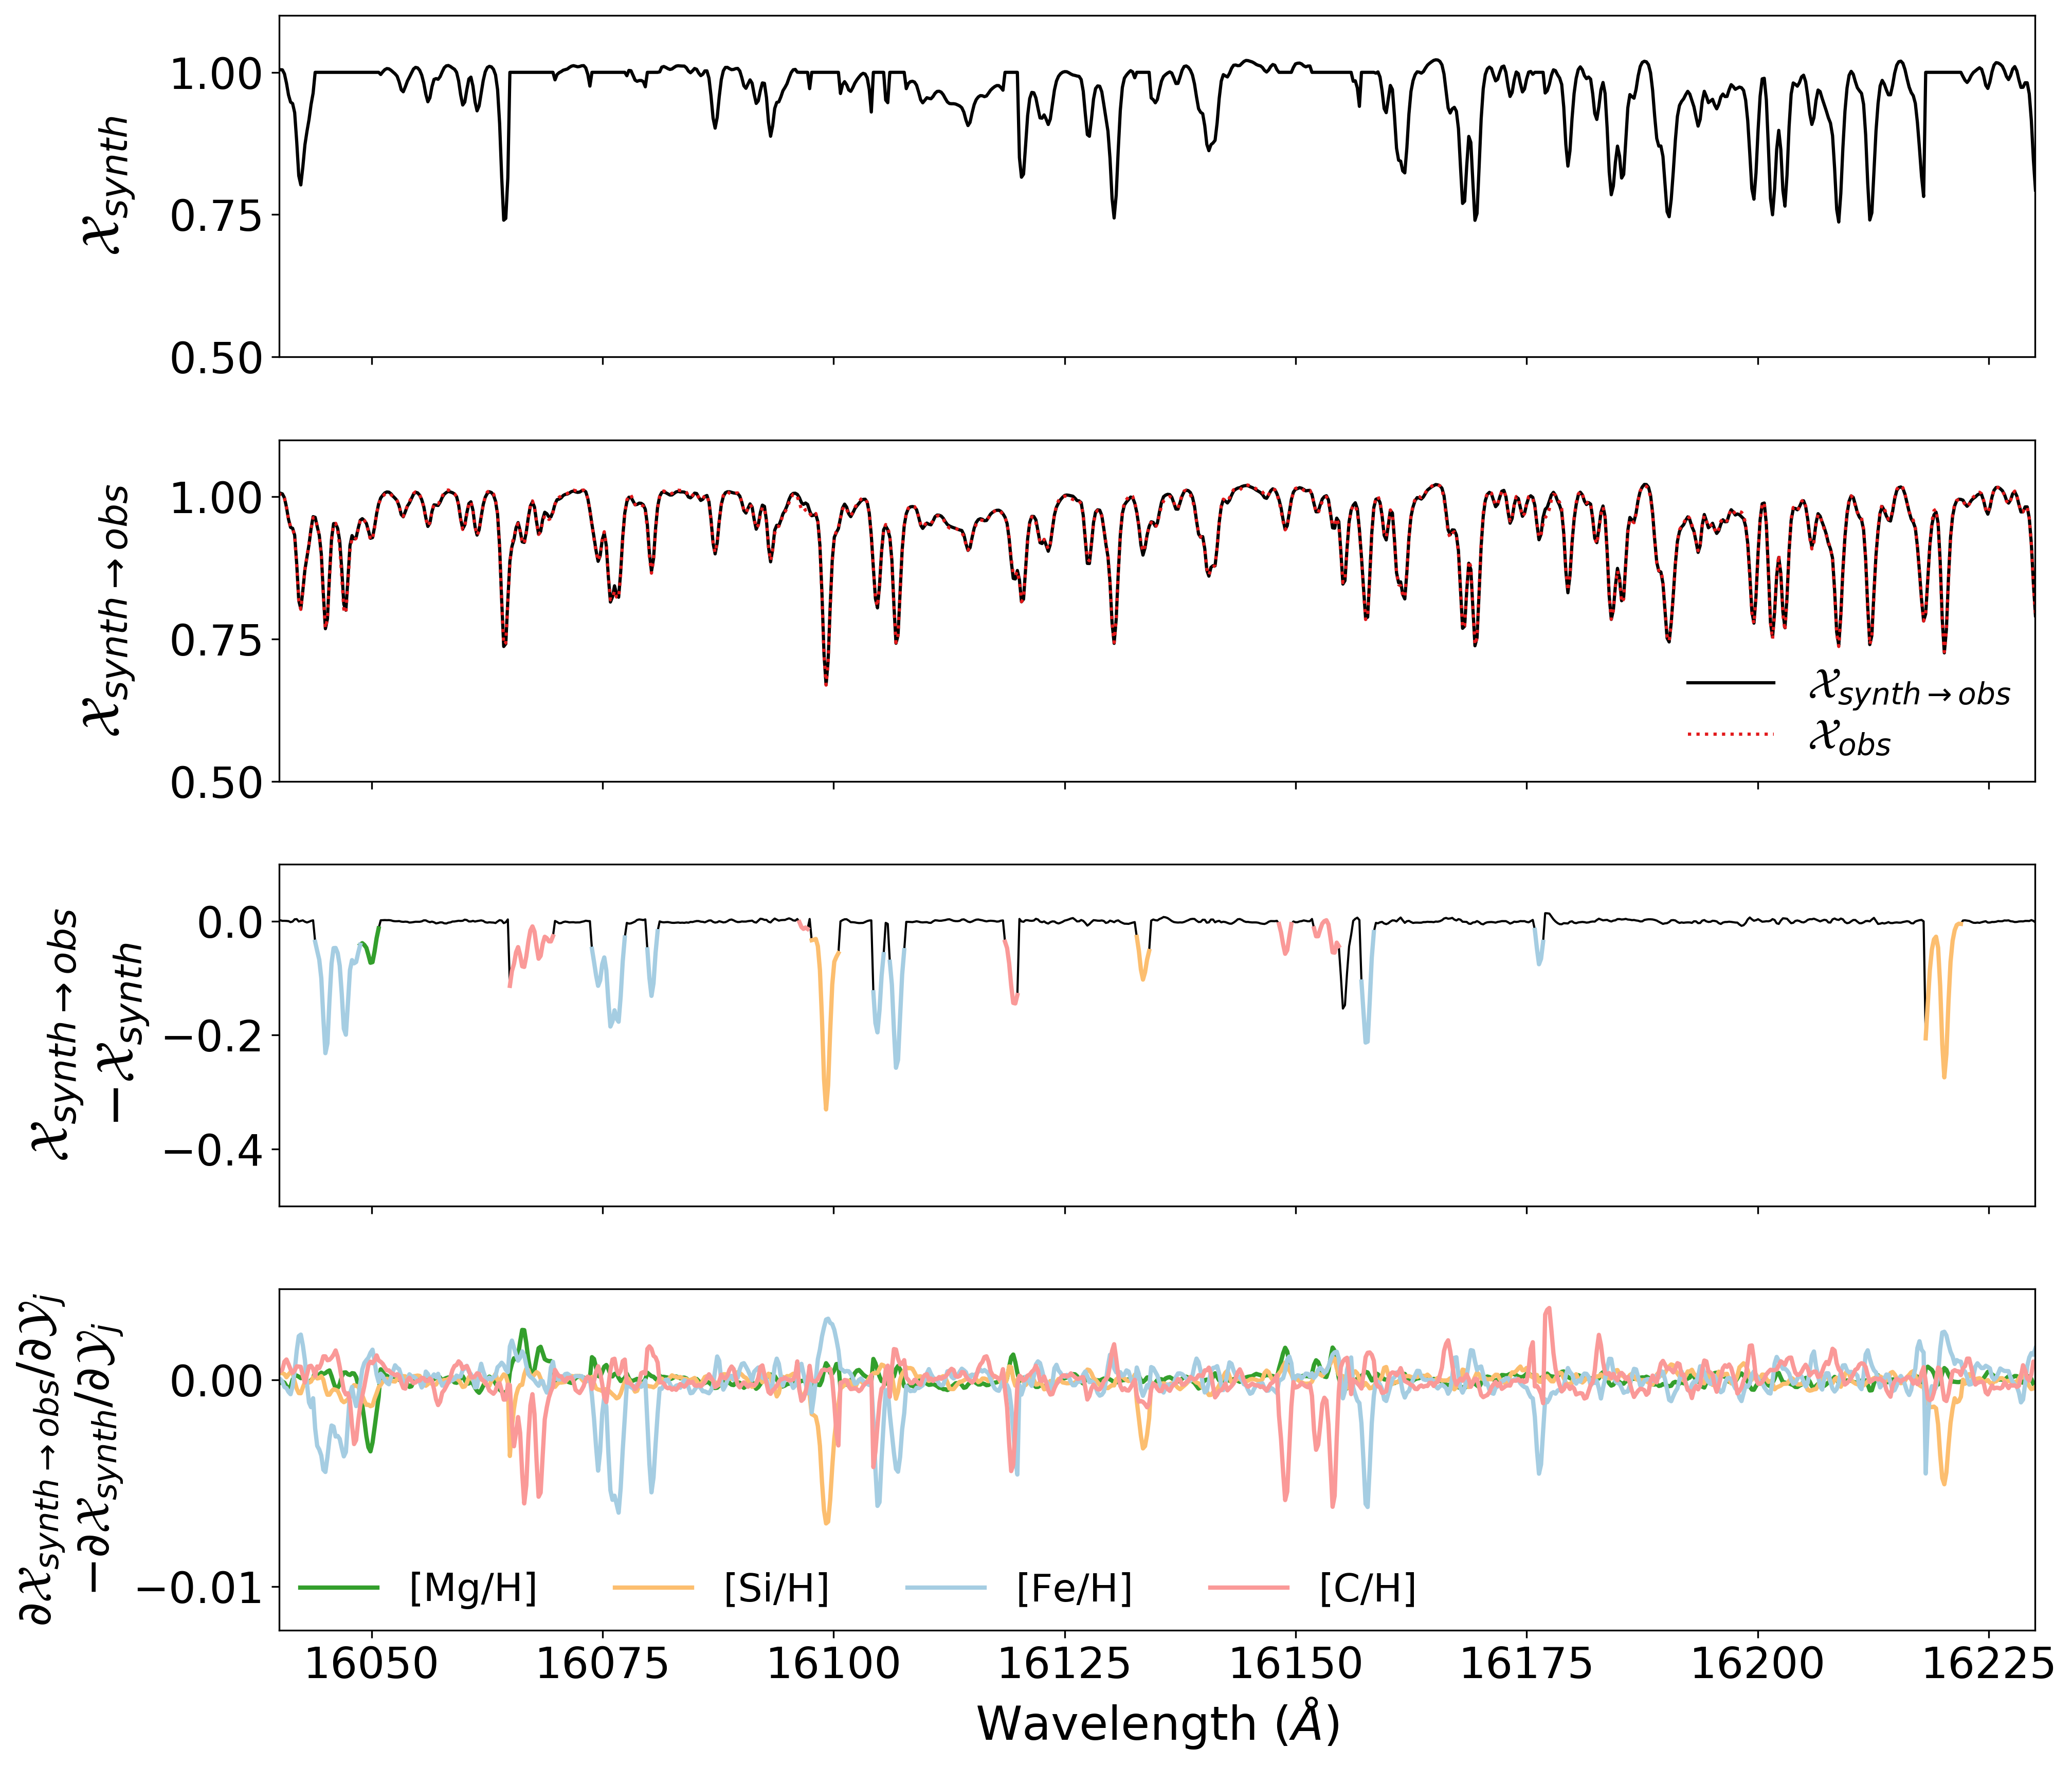

In [26]:
plt.close('all')

elem_labels = ['[C/H]', '[N/H]', '[O/H]', '[Na/H]', '[Mg/H]',
               '[Al/H]', '[Si/H]', '[P/H]', '[S/H]', '[K/H]',
               '[Ca/H]', '[Ti/H]', '[V/H]', '[Cr/H]', '[Mn/H]',
               '[Fe/H]', '[Co/H]', '[Ni/H]', '[Cu/H]', '[Ge/H]']

wave = wave_grid[47:]

#----------------------------------------------------------------------------------------
# atomic lines
ele_indices = [4, 6, 15, 0]
min_wave = 16040 # in Angstroms
max_wave = 16230
fig, axes = plt.subplots(4,1,figsize=(14,12), sharex=True)
ele_colors = [(51/256.,160/256.,44/256.,1.), (253/256.,191/256.,111/256.,1),\
              (166/256.,206/256.,227/256.,1.), (251/256.,154/256.,153/256.,1.)]

# molecular lines
# ele_indices = [0,1]
# min_wave = 15900 # in Angstroms
# max_wave = 16020
# fig, axes = plt.subplots(4,1,figsize=(14,12), sharex=True)
# ele_colors = [(253/256.,191/256.,111/256.,1), (166/256.,206/256.,227/256.,1.)]

#----------------------------------------------------------------------------------------
# Calculate residulal
x_resid = (x_obs.cpu().data.numpy()-x_synth)
x_resid = np.concatenate((np.zeros((1,47)),x_resid),1)

#----------------------------------------------------------------------------------------
# plot results
axes[0].plot(wave, x_synth[0], lw=1.5, c="black")
axes[1].plot(wave, x_obs[0].cpu().data.numpy(), lw=1.5, c="black", label=r'$\mathcal{X}_{synth \rightarrow obs}$')
axes[1].plot(wave, x_obs2[0].cpu().data.numpy(), lw=1.5, c=cb2[3], ls=":", label=r'$\mathcal{X}_{obs}$')
axes[2].plot(wave_grid, x_resid[0], lw=1., c="black")

#----------------------------------------------------------------------------------------
# Masks and jac_diff

for ele_index, ele_color in zip(ele_indices, ele_colors): 
    for i in range(len(start_count_mask[ele_index])):
        axes[2].plot(wave_grid[start_count_mask[ele_index][i]:end_count_mask[ele_index][i]],
                 x_resid[0,start_count_mask[ele_index][i]:end_count_mask[ele_index][i]], 
                 color=ele_color, lw=2.)
        
    # Plot the difference jacobian
    jac_, = axes[3].plot(wave, jac_diff[:,ele_index], 
                         c=ele_color, label=elem_labels[ele_index], lw=2) 
    
    
#----------------------------------------------------------------------------------------
# add text and legend
axes[3].legend(loc="best", ncol=4, fontsize=18, frameon=False,\
            borderpad=0.05, labelspacing=0.1)
axes[1].legend(loc="lower right", fontsize=20, frameon=False,\
            borderpad=0.05, labelspacing=0.1)

axes[0].set_xlim((min_wave,max_wave))
axes[0].set_ylim((0.5,1.1))
axes[1].set_ylim((0.5,1.1))
axes[2].set_ylim((-0.5,0.1))
for ax in axes:
    ax.tick_params(labelsize=20)
axes[0].set_ylabel(r'$\mathcal{X}_{synth}$',fontsize=25,labelpad=15)
axes[1].set_ylabel(r'$\mathcal{X}_{synth \rightarrow obs}$',fontsize=25,labelpad=15)
axes[2].set_ylabel(r'$\mathcal{X}_{synth \rightarrow obs}$' + '\n' + r'$- \mathcal{X}_{synth}$',fontsize=25)
axes[3].set_ylabel(r'$\partial\mathcal{X}_{synth \rightarrow obs}/\partial \mathcal{Y}_j$'\
                   + '\n' + r'$- \partial\mathcal{X}_{synth}/\partial \mathcal{Y}_j$',fontsize=22)

plt.xlabel(r'Wavelength ($\AA$)',fontsize=22)
plt.tight_layout()
plt.savefig('fig10.png')


In [ ]:
plt.close('all')

elem_labels = ['[C/H]', '[N/H]', '[O/H]', '[Na/H]', '[Mg/H]',
               '[Al/H]', '[Si/H]', '[P/H]', '[S/H]', '[K/H]',
               '[Ca/H]', '[Ti/H]', '[V/H]', '[Cr/H]', '[Mn/H]',
               '[Fe/H]', '[Co/H]', '[Ni/H]', '[Cu/H]', '[Ge/H]']

wave = wave_grid[47:]

#----------------------------------------------------------------------------------------
# atomic lines
ele_indices = [4, 6, 15]
min_wave = 16040 # in Angstroms
max_wave = 16230
fig, axes = plt.subplots(3,1,figsize=(14,9), sharex=True)
ele_colors = [((256-251)/256.,(256-154)/256.,(256-153)/256.,1.), ((256-253)/256.,(256-191)/256.,(256-111)/256.,1),\
              ((256-166)/256.,(256-206)/256.,(256-227)/256.,1.)]

# molecular lines
#ele_indices = [0,1]
#min_wave = 15965 # in Angstroms
#max_wave = 16030
#fig, axes = plt.subplots(4,1,figsize=(10,11), sharex=True)
#ele_colors = [(253/256.,191/256.,111/256.,1), (166/256.,206/256.,227/256.,1.)]

#----------------------------------------------------------------------------------------
# Calculate residulal
x_resid = (x_obs.cpu().data.numpy())
x_resid = np.concatenate((np.zeros((1,47)),x_resid),1)

#----------------------------------------------------------------------------------------
# plot results
axes[1].plot(wave, x_synth[0], lw=1.5, c="black")
axes[0].plot(wave, x_obs[0].cpu().data.numpy(), lw=1.5, c="black", ls=":")
#axes[0].plot(wave, x_obs[0].cpu().data.numpy(), lw=1.5, c='black')

#----------------------------------------------------------------------------------------
# Masks and jac_diff

for ele_index, ele_color in zip(ele_indices, ele_colors): 
    for i in range(len(start_count_mask[ele_index])):
        axes[0].plot(wave_grid[start_count_mask[ele_index][i]:end_count_mask[ele_index][i]],
                 x_resid[0,start_count_mask[ele_index][i]:end_count_mask[ele_index][i]], 
                 color=ele_color, lw=2.)
        
    # Plot the difference jacobian
    jac_, = axes[2].plot(wave, jac_diff[:,ele_index], 
                         c=ele_color, label=elem_labels[ele_index], lw=2) 
    jac_, = axes[0].plot(wave, jac_diff[:,ele_index], 
                         c=ele_color, label=elem_labels[ele_index], lw=2) 
    
#----------------------------------------------------------------------------------------
# add text and legend
axes[2].legend(loc="lower left", ncol=3, fontsize=18, frameon=False,\
            borderpad=0.05, labelspacing=0.1)
axes[0].legend(loc="lower left", ncol=3, fontsize=18, frameon=False,\
            borderpad=0.05, labelspacing=0.1)

axes[1].set_xlim((min_wave,max_wave))
axes[1].set_ylim((0.5,1.1))
axes[0].set_ylim((0.5,1.1))
for ax in axes:
    ax.tick_params(labelsize=20)
axes[1].set_ylabel(r'$\mathcal{X}_{synth}$',fontsize=25,labelpad=15)
axes[0].set_ylabel(r'$\mathcal{X}_{synth \rightarrow obs}$',fontsize=25,labelpad=15)
axes[2].set_ylabel(r'$\partial\mathcal{X}_{synth \rightarrow obs}/\partial \mathcal{Y}_j$'\
                   + '\n' + r'$- \partial\mathcal{X}_{synth}/\partial \mathcal{Y}_j$',fontsize=22)

plt.xlabel(r'Wavelength ($\AA$)',fontsize=22)
plt.tight_layout()
#plt.savefig('fig10.png')
